In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.stats import norm

In [2]:
data = np.load("energy_pdfs.npz")
pdf_A = data['pdf_A']
pdf_B  = data['pdf_B']
pdf_C = data['pdf_C']
pdf_ovbb = data['pdf_ovbb']
bin_edges = data['bin_edges']
bin_centers = data['bin_centers']
counts_Target = data['counts_Target']

In [3]:
mu_nl = 2039.0
sigma_nl = 1.0

In [4]:
pdf_A = pdf_A / np.sum(pdf_A)
pdf_B = pdf_B / np.sum(pdf_B)
pdf_C = pdf_C / np.sum(pdf_C)
pdf_ovbb = pdf_ovbb / np.sum(pdf_ovbb)

In [5]:
nbins = len(bin_centers)
N_obs = counts_Target.sum()
bin_width = (bin_centers[1] - bin_centers[0])

def expected_counts(theta):
    thetaA, thetaB, thetaC, thetaNL = theta
    mu = thetaA * pdf_A + thetaB * pdf_B + thetaC * pdf_C + thetaNL * pdf_ovbb
    return mu

In [6]:
thetaA_mean, thetaA_sigma = 1350.0, 100.0
thetaB_mean, thetaB_sigma = 770.0, 270.0
sigma_C = 2000.0
sigma_NL = 2000.0

In [7]:
def log_prior(theta):
    thetaA, thetaB, thetaC, thetaNL = theta
    if thetaA < 0 or thetaB < 0 or thetaC < 0 or thetaNL < 0:
        return -np.inf

    # Gaussian log-priors for A and B
    lp = -0.5 * ((thetaA - thetaA_mean) / thetaA_sigma) ** 2 - np.log(thetaA_sigma * np.sqrt(2*np.pi))
    lp += -0.5 * ((thetaB - thetaB_mean) / thetaB_sigma) ** 2 - np.log(thetaB_sigma * np.sqrt(2*np.pi))

    # half-normal (x>=0) log-prior for C and NL: density = sqrt(2)/(sigma*sqrt(pi)) * exp(-x^2/(2 sigma^2))
    lp += np.log(np.sqrt(2/(np.pi))) - np.log(sigma_C) - 0.5 * (thetaC / sigma_C) ** 2
    lp += np.log(np.sqrt(2/(np.pi))) - np.log(sigma_NL) - 0.5 * (thetaNL / sigma_NL) ** 2

    return lp

In [8]:
def log_likelihood(theta):
    mu = expected_counts(theta)
    mu = np.clip(mu, 1e-12, None)
    k = counts_Target
    return np.sum(k * np.log(mu) - mu)

In [9]:
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta)
    return lp + ll

In [10]:
ndim = 4
nwalkers = 50
rng = np.random.default_rng(24352)
init_theta = np.array([thetaA_mean, thetaB_mean, 500.0, 500.0])
p0 = init_theta + init_theta * 0.05 * rng.standard_normal((nwalkers, ndim))
p0 = np.clip(p0, 1e-6, None)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
print("Running burn-in...")
pos, prob, state = sampler.run_mcmc(p0, 1500, progress=True)
sampler.reset()
print("Running main sampling...")
sampler.run_mcmc(pos, 3000, progress=True)

samples = sampler.get_chain(flat=True)
print("Samples shape:", samples.shape)

names = ["thetaA", "thetaB", "thetaC", "thetaNL"]
import numpy as np
def summarize(arr, name):
    med = np.percentile(arr, 50)
    lo = np.percentile(arr, 16)
    hi = np.percentile(arr, 84)
    p90 = np.percentile(arr, 90)
    print(f"{name}: median={med:.2f}, -{med-lo:.2f}/+{hi-med:.2f}, 90pct={p90:.2f}")
    return med, lo, hi, p90

for i, n in enumerate(names):
    summarize(samples[:, i], n)

Running burn-in...


100%|██████████| 1500/1500 [00:03<00:00, 394.72it/s]


Running main sampling...


100%|██████████| 3000/3000 [00:07<00:00, 397.71it/s]

Samples shape: (150000, 4)
thetaA: median=643.12, -60.13/+60.70, 90pct=721.54
thetaB: median=329.27, -63.58/+60.40, 90pct=407.35
thetaC: median=76.86, -48.79/+62.09, 90pct=157.77
thetaNL: median=8.74, -3.37/+4.08, 90pct=14.17


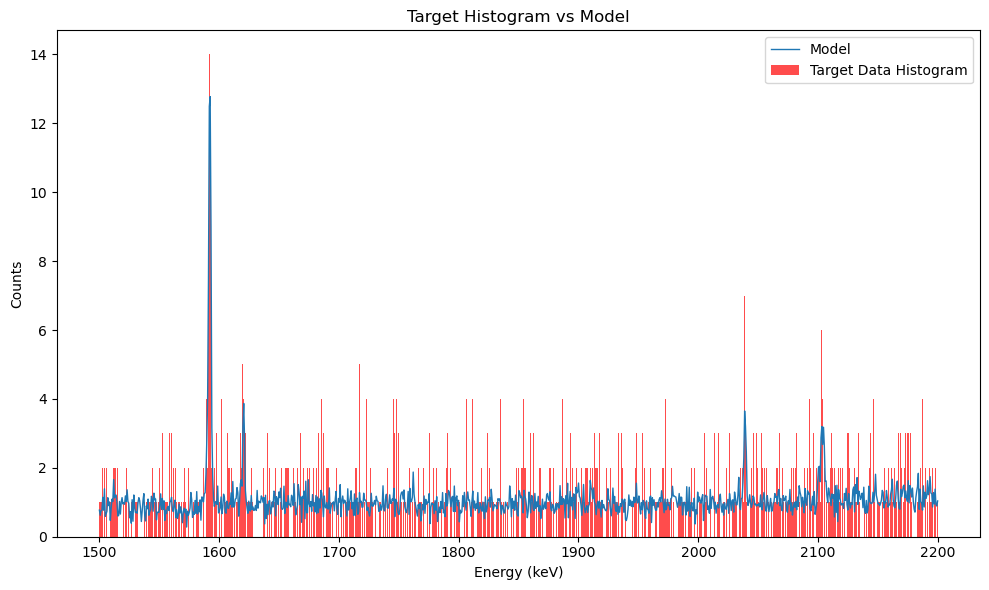

In [22]:
thetaA_med, thetaB_med, thetaC_med, thetaNL_med = np.median(samples, axis=0)
model_counts = (
    thetaA_med * pdf_A +
    thetaB_med * pdf_B +
    thetaC_med * pdf_C +
    thetaNL_med * pdf_ovbb
)
plt.figure(figsize=(10,6))
#plt.step(bin_centers, counts_Target, where="mid", label="Target Data", linewidth=1.5)
plt.bar(bin_centers, counts_Target, width=bin_width, color="red", label="Target Data Histogram", alpha=0.7)
plt.plot(bin_centers, model_counts, label="Model", linewidth=1)

plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Target Histogram vs Model")
plt.legend()
plt.tight_layout()
plt.show()

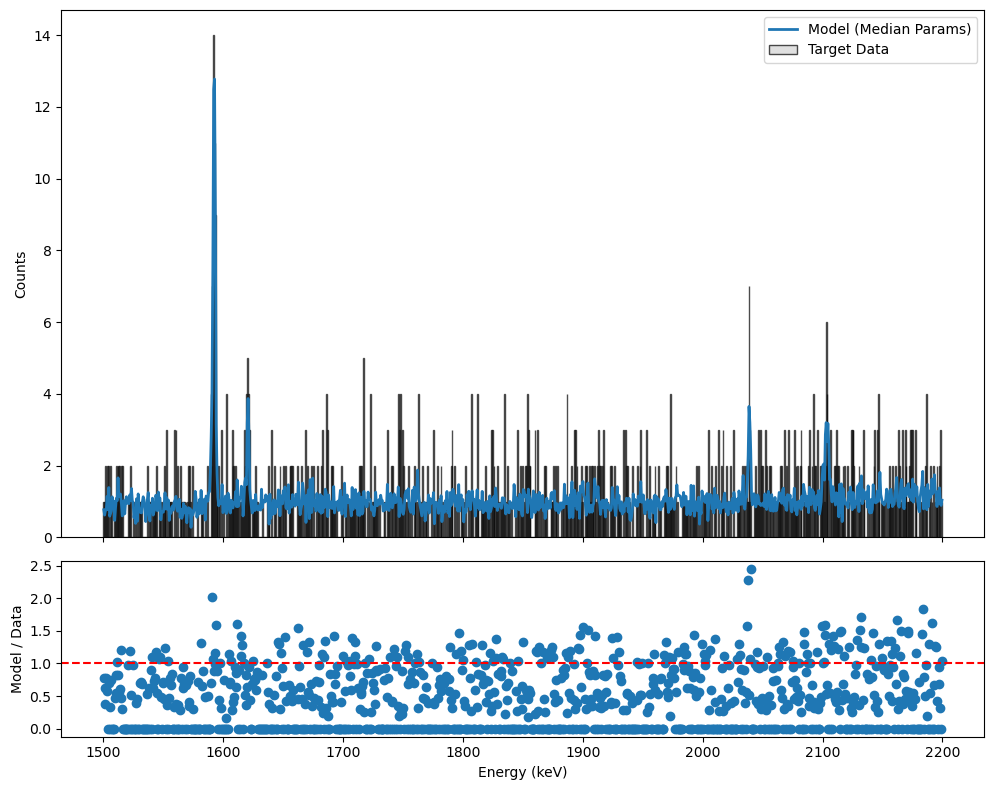

In [34]:
ratio = np.divide(
    model_counts,
    counts_Target,
    out=np.zeros_like(model_counts),
    where=counts_Target > 0
)
fig, (ax1, ax2) = plt.subplots(
    2, 1, 
    figsize=(10, 8), 
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)
ax1.bar(
    bin_centers,
    counts_Target,
    width=bin_width,
    color="lightgray",
    edgecolor="black",
    label="Target Data",
    alpha=0.7
)
ax1.plot(
    bin_centers,
    model_counts,
    linewidth=2,
    label="Model (Median Params)"
)
ax1.set_ylabel("Counts")
ax1.legend()
ax2.plot(bin_centers, ratio, marker='o', linestyle='none')
ax2.axhline(1.0, color='red', linestyle='--')   # perfect agreement line
ax2.set_ylabel("Model / Data")
ax2.set_xlabel("Energy (keV)")

plt.tight_layout()
plt.show()